<h3>Step 1: Data Loading</h3>

In [12]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           roc_curve, roc_auc_score, precision_score, recall_score, f1_score)
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc


# Load dataset
file_path = r"C:\Users\lenovo\Desktop\SentinelNet\Datasets\cicids2017\DoS-Wednesday-no-metadata (1).parquet"
df = pd.read_parquet(file_path)

print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset info:")
print(df.info())

Dataset shape: (584991, 78)

First 5 rows:
   Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0         6          38308                  1                       1   
1         6            479                 11                       5   
2         6           1095                 10                       6   
3         6          15206                 17                      12   
4         6           1092                  9                       6   

   Fwd Packets Length Total  Bwd Packets Length Total  Fwd Packet Length Max  \
0                         6                         6                      6   
1                       172                       326                     79   
2                      3150                      3150                   1575   
3                      3452                      6660                   1313   
4                      3150                      3152                   1575   

   Fwd Packet Length Min  Fwd Packet 

<h3>Step 2: Data Cleaning</h3>

In [13]:
# Check and drop missing values if any
print("Missing values in dataset:", df.isnull().sum().sum())
if df.isnull().sum().sum() > 0:
    df.dropna(inplace=True)
    print("Missing values dropped")

# Remove duplicates
before = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"Removed {before - df.shape[0]} duplicates. New shape: {df.shape}")

Missing values in dataset: 0
Removed 0 duplicates. New shape: (584991, 78)


<h3> Step 3: Target Label Creation and Distribution Plot</h3>

Class distribution:
attack_binary
0    391235
1    193756
Name: count, dtype: int64

Class distribution (%):
attack_binary
0    66.878807
1    33.121193
Name: proportion, dtype: float64


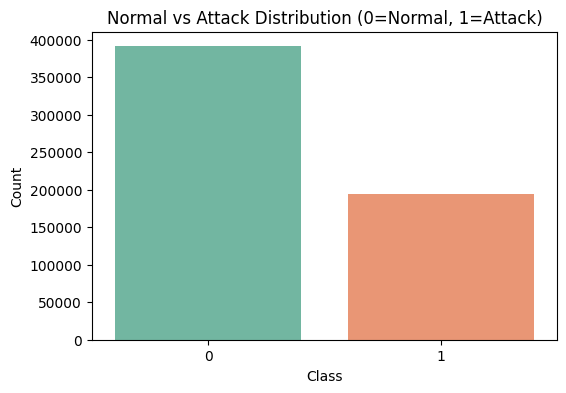

In [14]:
# Create binary target variable: 0 = Benign, 1 = Attack 
df['attack_binary'] = df['Label'].apply(lambda x: 0 if str(x).lower() == 'benign' else 1)

# Check class distribution
print("Class distribution:")
print(df['attack_binary'].value_counts())
print("\nClass distribution (%):")
print(df['attack_binary'].value_counts(normalize=True) * 100)

# Plot class distribution 
plt.figure(figsize=(6,4))
sns.countplot(x='attack_binary', data=df, hue='attack_binary', palette="Set2", legend=False)
plt.title("Normal vs Attack Distribution (0=Normal, 1=Attack)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

<h3> Step 4: Top 10 attack types plot </h3>

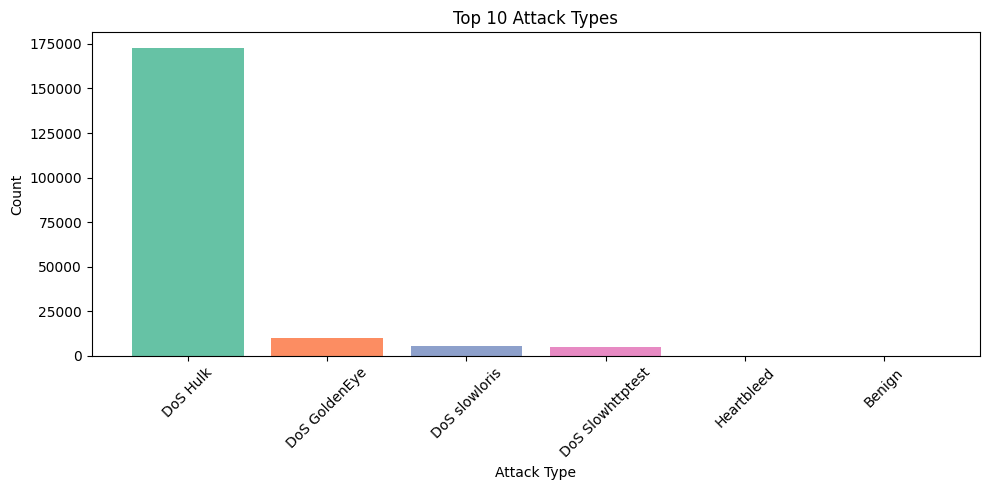

In [15]:
# Top 10 attack types plot 
attack_counts = df[df['Label'].str.lower() != 'benign']['Label'].value_counts().head(10)

plt.figure(figsize=(10,5))
bars = plt.bar(attack_counts.index, attack_counts.values)
colors = sns.color_palette("Set2", len(attack_counts))
for i, bar in enumerate(bars):
    bar.set_facecolor(colors[i])

plt.title("Top 10 Attack Types")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<h3>Step 5: Feature Encoding</h3>

In [16]:
# Identify categorical columns except 'Label' and target
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ['Label', 'attack_binary']]

print("Categorical columns to encode:", categorical_cols)

# One-hot encode categorical columns if any exist
if categorical_cols:
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    print(f"Shape after encoding: {df_encoded.shape}")
else:
    df_encoded = df.copy()
    print("No categorical columns to encode")

# Prepare features and target
exclude_cols = ['Label', 'attack_binary']
X = df_encoded.drop(columns=exclude_cols)
y = df_encoded['attack_binary']

print("Feature columns:", len(X.columns))
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Categorical columns to encode: []
No categorical columns to encode
Feature columns: 77
Features shape: (584991, 77)
Target shape: (584991,)


<h3>Step 6: Feature Scaling</h3>

In [17]:
# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

print("Features scaled successfully")
print("Scaled features range:")
print(f"Min: {X_scaled.min().min():.3f}")
print(f"Max: {X_scaled.max().max():.3f}")

Features scaled successfully
Scaled features range:
Min: 0.000
Max: 1.000


<h3>Step 7: Prepare Features and Target</h3>

In [18]:
X = df.drop(columns=exclude_cols)
y = df['attack_binary']

# Train-test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Train set:", X_train.shape)
print("Test set:", X_test.shape)

Train set: (467992, 77)
Test set: (116999, 77)


<h3> Step 8: Train-Test Split </h3>

In [19]:
# Train-test split 
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set:", X_train.shape)
print("Test set:", X_test.shape)
print("Train class distribution:")
print(y_train.value_counts(normalize=True))

Train set: (467992, 77)
Test set: (116999, 77)
Train class distribution:
attack_binary
0    0.668787
1    0.331213
Name: proportion, dtype: float64


<h3> Step 9: Model Training and Validation</h3>

In [20]:
# Train-validation split for model selection
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Training set:", X_train_final.shape)
print("Validation set:", X_val.shape)

Training set: (374393, 77)
Validation set: (93599, 77)


In [22]:
# Import necessary libraries
import time
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


<h3> Step 10: Train and Evaluates model </h3>

In [23]:
# Initial model validation
initial_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

print("\n=== Initial Model Validation ===")
for name, model in initial_models.items():
    start_time = time.time()
    model.fit(X_train_final, y_train_final)
    end_time = time.time()

    y_val_pred = model.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)

    cm = confusion_matrix(y_val, y_val_pred)
    TN, FP, FN, TP = cm.ravel()
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    training_time = end_time - start_time

    print(f"\n{name}:")
    print(f"  Validation Accuracy: {val_acc * 100:.2f}%")
    print(f"  Specificity: {specificity:.4f}")
    print(f"  Training Time: {training_time:.4f} seconds")


=== Initial Model Validation ===

Logistic Regression:
  Validation Accuracy: 97.21%
  Specificity: 0.9933
  Training Time: 15.4301 seconds

Decision Tree:
  Validation Accuracy: 99.92%
  Specificity: 0.9993
  Training Time: 35.2576 seconds

Random Forest:
  Validation Accuracy: 99.86%
  Specificity: 0.9990
  Training Time: 199.5976 seconds

Gradient Boosting:
  Validation Accuracy: 99.70%
  Specificity: 0.9991
  Training Time: 808.3796 seconds


<h3>Step 11: Model Training and Evaluation</h3>

In [24]:
# Optimized models with better hyperparameters
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, 
        random_state=42, 
        class_weight="balanced", 
        C=0.5
    ),
    "Decision Tree": DecisionTreeClassifier(
        random_state=42, 
        max_depth=8, 
        min_samples_split=10, 
        min_samples_leaf=5
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=120,
        random_state=42,
        n_jobs=-1,
        max_depth=12,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight="balanced_subsample"
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=42,
        n_estimators=150,
        learning_rate=0.1,
        max_depth=3
    )
}

# Training and testing evaluation
print("\n=== Final Model Evaluation ===")
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    # Training accuracy
    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    print(f"{name} Training Accuracy: {train_acc * 100:.2f}%")
    
    # Testing accuracy
    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    results[name] = test_acc
    print(f"{name} Testing Accuracy: {test_acc * 100:.2f}%")
    
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Normal", "Attack"]))


=== Final Model Evaluation ===

Training Logistic Regression...
Logistic Regression Training Accuracy: 96.92%
Logistic Regression Testing Accuracy: 97.04%

Logistic Regression Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98     78248
      Attack       0.94      0.98      0.96     38751

    accuracy                           0.97    116999
   macro avg       0.96      0.97      0.97    116999
weighted avg       0.97      0.97      0.97    116999


Training Decision Tree...
Decision Tree Training Accuracy: 99.06%
Decision Tree Testing Accuracy: 99.08%

Decision Tree Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99     78248
      Attack       0.99      0.98      0.99     38751

    accuracy                           0.99    116999
   macro avg       0.99      0.99      0.99    116999
weighted avg       0.99      0.99      0.99    116999


T

<h3>Step 12: Visualization of Results</h3>

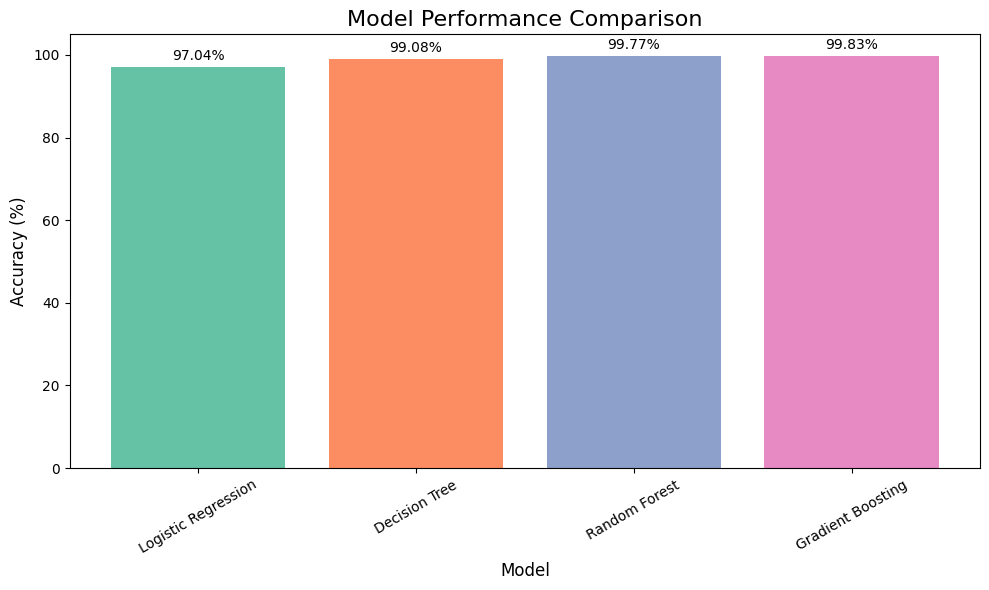


=== Performance Summary ===
Logistic Regression: 97.04%
Decision Tree: 99.08%
Random Forest: 99.77%
Gradient Boosting: 99.83%


In [31]:
# Accuracy barplot with percentage values
results_df = pd.DataFrame([
    {'Model': name, 'Accuracy': acc * 100} 
    for name, acc in results.items()
])

plt.figure(figsize=(10, 6))
bars = plt.bar(results_df['Model'], results_df['Accuracy'])

# Apply Set2 colors
colors = sns.color_palette("Set2", len(results_df))
for i, bar in enumerate(bars):
    bar.set_facecolor(colors[i])

plt.title('Model Performance Comparison', fontsize=16)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 105)
plt.xticks(rotation=30)

# Add accuracy labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.2f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Print performance summary
print("\n=== Performance Summary ===")
for name, acc in results.items():
    print(f"{name}: {acc*100:.2f}%")

<h3>Step 13: Confusion matrix for best model</h3>


=== Best Model: Gradient Boosting ===
Test Accuracy: 0.9983 (99.83%)


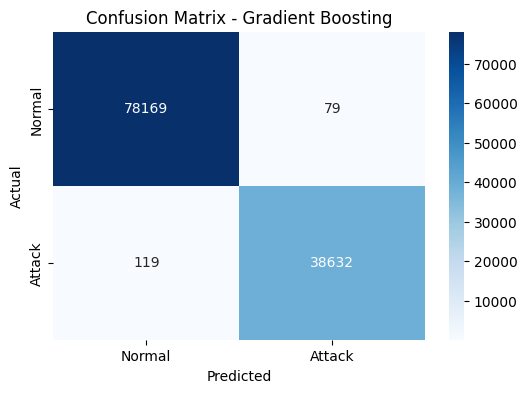


Detailed Metrics for Gradient Boosting:
True Negatives (Normal correctly identified): 78169
False Positives (Normal misclassified as Attack): 79
False Negatives (Attack misclassified as Normal): 119
True Positives (Attack correctly identified): 38632

Calculated Metrics:
Accuracy: 0.9983 (99.83%)
Precision: 0.9980
Recall (Sensitivity): 0.9969
Specificity: 0.9990


In [32]:
# Select best performing model
best_model_name = max(results.keys(), key=lambda k: results[k])
best_model = models[best_model_name]
best_accuracy = results[best_model_name]

print(f"\n=== Best Model: {best_model_name} ===")
print(f"Test Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

# Generate predictions with best model
y_pred_best = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate metrics from confusion matrix
if cm.shape == (2, 2):
    TN, FP, FN, TP = cm.ravel()
    
    accuracy_cm = (TN + TP) / (TN + FP + FN + TP)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    print(f"\nDetailed Metrics for {best_model_name}:")
    print(f"True Negatives (Normal correctly identified): {TN}")
    print(f"False Positives (Normal misclassified as Attack): {FP}")
    print(f"False Negatives (Attack misclassified as Normal): {FN}")
    print(f"True Positives (Attack correctly identified): {TP}")
    
    print(f"\nCalculated Metrics:")
    print(f"Accuracy: {accuracy_cm:.4f} ({accuracy_cm*100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")

<h3> Step 14:  ROC Curve for all models</h3>

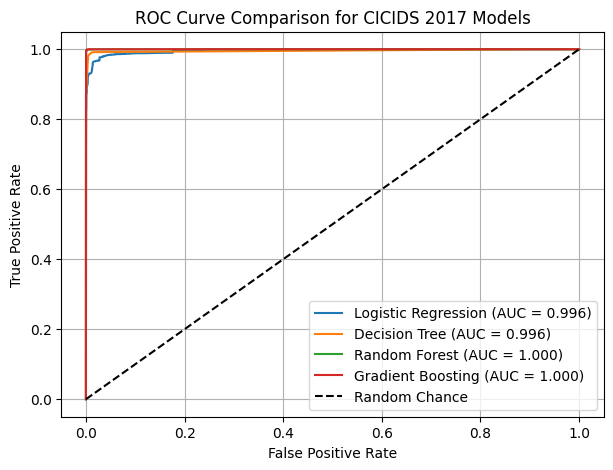

In [33]:
# ROC Curve Comparison
plt.figure(figsize=(7, 5))

for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc_score = roc_auc_score(y_test, y_probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.title('ROC Curve Comparison for CICIDS 2017 Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

<h3> Step 15: Box Plot </h3>

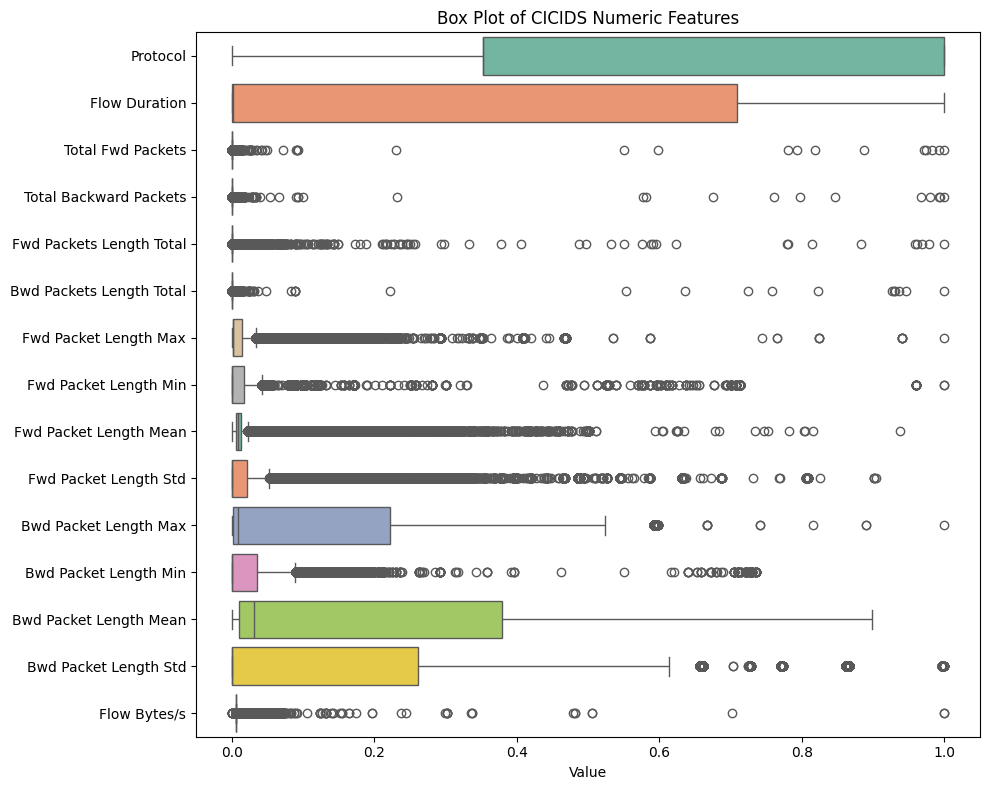

In [36]:
# Box plot of numeric features
numeric_cols_cicids = X_train.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(10, 8))
subset_cols = numeric_cols_cicids[:15]  
sns.boxplot(data=X_train[subset_cols], orient='h', palette="Set2")
plt.title('Box Plot of CICIDS Numeric Features')
plt.xlabel('Value')
plt.tight_layout()
plt.show()

<h3> Step 16: Correlation Heatmap </h3>

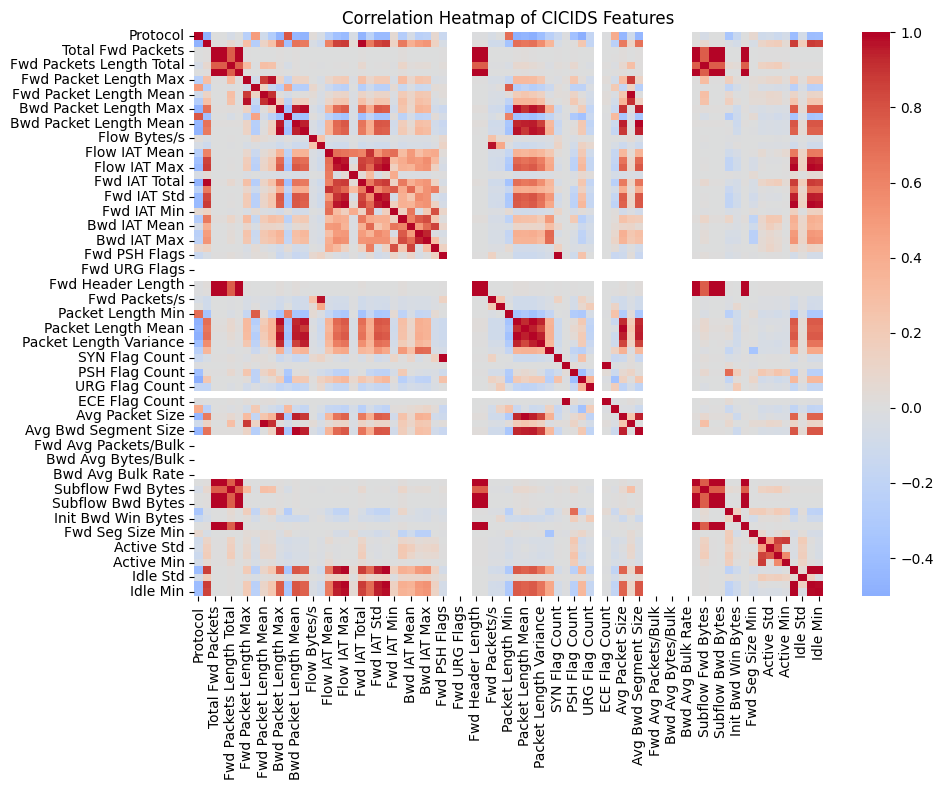

In [37]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
corr_cicids = X_train.corr()
sns.heatmap(corr_cicids, cmap='coolwarm', center=0, annot=False, fmt=".2f", cbar=True)
plt.title('Correlation Heatmap of CICIDS Features')
plt.tight_layout()
plt.show()